# Intro to the OpenOA `PlantData` and QA Methods

In this example we will be using the ENGIE open data set for the La Haute Borne wind power plant, and demonstrating how to use the quality assurance (QA) methods in OpenOA to help get this data ready for use with the `PlantData` class. This notebook will walk through the creation of the `project_Engie` module, especially the `prepare()` method that returns either the cleaned data or a `PlantData` object.

While we work with `project_ENGIE.py` to standardize the QCing of the La Haute Borne data, it should be noted that the use of an external script to load in data is entirely optional. For instance, a user could do all their work in a single script, set up a template Jupyter Notebook for working with data, or any other means that produces the data that can be read into `PlantData` and the associated metadata (`PlantMetaData`), as determined by the user input data.

## The `PlantData` object

The `PlantData` object is the core data structure for OpenOA, which is used for importing and validating wind power plant operational data for analysis in OpenOA. 

### What's changed in v3?

For users that are well acquainted with OpenOA and its data structures, there are a few changes to the ways the code now operates:
- All data objects such as `PlantData.scada` are pandas `DataFrame`s now, so there is no longer the need to access the data via `PlantData.scada._df`
- Because all data objects are pandas `DataFrame`s, `AssetData` and `ReanalysisData` have been dropped in favor of: `PlantData.asset` and `PlantData.reanalysis`, respectively.
- Reanalysis data is the only data object that diverges, and is now a dictionary of `DataFrame`s, which enables the use of an arbitrary number of reanalysis products to be imported and used
- There are now a number of convenience methods, such as `PlantData.turbine_ids`, `PlantData.tower_ids`, `PlantData.turbine_df()`, and `PlantData.tower_df()` for commonly used data access routines.
- `PlantData` is now accompanied by a `PlantMetaData` object that is powered by dictionaries to help routinely set up mappings between user data formats and OpenOA internal formats that use an IEC-25 schematic.

### `PlantData` and `PlantMetaData` 101

The `PlantData` object, as previously stated, is the central data repository and object for working with operational data in OpenOA. All of the analysis methods are built around this object for both API consistency and to make OpenOA easily extensible to new/more analysis methods. For the OpenOA examples, the metadatafile: `data/plant_meta.yml` will be used (and a JSON reference for those that prefer JSON: `data/plant_meta.json`) to map the La Haute Borne fields to the OpenOA fields. This v3 update allows a user to bring their data directly into a `PlantData` object with a means for the OpenOA to know which data fields are being used 

Below is a demonstration of loading a `PlantMetaData`object directly to show what data are
expected, though there is a `PlantMetaData.load()` that can accept a dictionary or file path input for routinized workflows.

```python
metadata = PlantMetaData(
    latitude,  # float
    longitude,  # float
    scada,  # dictionary of column mappings and data frequency
    meter,  # dictionary of column mappings and data frequency
    tower,  # dictionary of column mappings and data frequency
    status,  # dictionary of column mappings and data frequency
    curtail,  # dictionary of column mappings and data frequency
    asset,  # dictionary of column mappings
    reanalysis,  # dictionary of each product's dictionary of column mappings and data frequency
)
```
For each of the data objects above, there is a corresponding meta data class to help guide users. For instance, the `SCADAMetaData` (below) has pre-set attributes to help guide users outside of the docstrings and standard documentation. The other meta data objects are: `MeterMetaData`, `TowerMetaData`, `StatusMetaData`, `CurtailMetaData`, `AssetMetaData`, and `ReanalysisMetaData` (one is created for each producted provided).

For example, each of the metadata classes allows inputs for the column mappings and timestamp frequency to enable the data validation steps outlined in [Step 5](#Step-5:-Translating-this-work-into-a-data-loading-script-for-PlantData). However to clarify the units and data types exected, each of the metadata classes contains the immutable attributes: `units` and `dtypes`, as shown below for the `SCADAMetaData` class, to signal to users what units each data input should be in, when passed, and what type the data should be able to be converted to, if it's not already in that format. Some examples of acceptable formats would be string-encode floats, or string-encoded timestamps, both of which can be automatically converted in the initialization steps.

In [1]:
from pprint import pprint
from openoa.plant import SCADAMetaData

scada_meta = SCADAMetaData()  # no inputs means use the default, internal mappings
print("Expected units for each column in the SCADA data:")
pprint(scada_meta.units)
print()
print("Expected data types for each column in the SCADA data:")
pprint(scada_meta.dtypes)

Expected units for each column in the SCADA data:
{'energy': 'kWh',
 'id': None,
 'pitch': 'deg',
 'power': 'kW',
 'status': None,
 'temperature': 'C',
 'time': 'datetim64[ns]',
 'wind_direction': 'deg',
 'windspeed': 'm/s'}

Expected data types for each column in the SCADA data:
{'energy': <class 'float'>,
 'id': <class 'str'>,
 'pitch': <class 'float'>,
 'power': <class 'float'>,
 'status': <class 'str'>,
 'temperature': <class 'float'>,
 'time': <class 'numpy.datetime64'>,
 'wind_direction': <class 'float'>,
 'windspeed': <class 'float'>}


Below is a demonstration of loading a `PlantData` object directly, though there are class methods for loading from file or an ENTR warehouse.
```python
plant = PlantData(
    metadata,  # PlantMetaData, dictionary, or file
    analysis_type,  # list of analysis types expected to be performed, "all", or None
    scada,  # None, DataFrame or CSV file path
    meter,  # None, DataFrame or CSV file path
    tower,  # None, DataFrame or CSV file path
    status,  # None, DataFrame or CSV file path
    curtail,  # None, DataFrame or CSV file path
    asset,  # None, DataFrame or CSV file path
    reanalysis,  # None, dictionary of DataFrames or CSV file paths with the name of the product for keys
)
```

On loading, the data will be validated automatically according to the `analysis_type` input(s) provided to ensure columns exist with the expected names, data types are correct, and data frequencies are of a sufficient resolution. However, while all erros in this process are caught, only those of concern to an `analysis_type` are raised, with the exception of "all" raises any error found and `None` ignore all errors.

## Imports

In [2]:
from pprint import pprint

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from openoa import PlantData
from openoa.utils import qa
from openoa.utils import plot

import project_ENGIE

# Avoid clipping data previews unnecessarily
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

## Using ENGIE's open data set

ENGIE provides access to the data of its 'La Haute Borne' wind farm through https://opendata-renewables.engie.com and through an API. The data gives users the opportunity to work with real-world operational data. 

The series of notebooks in the 'examples' folder uses SCADA data downloaded from https://opendata-renewables.engie.com, saved in the `examples/data` folder. Additional plant level meter, availability, and curtailment data were synthesized based on the SCADA data.

The data used throughout these examples are pre-processed appropriately for the issues described in the subsequent sections, and synthesized into a routinized format in the `examples/project_ENGIE.py` Python script.

**Note**: This demonstration is centered around a specific data set, so it should be noted that there are other methods for working with data that are not featured here, and we would like to point the user to the API documentation for further data checking and manipulation methods.

### Step 1: Load the SCADA data

First we'll need to unzip the data, and read the SCADA data to a pandas `DataFrame` so we can take a look at the data before we can start working with it. Here the `project_ENGIE.extract_data()` method is used to unzip the data folder because this demonstration is based on working with the ENGIE provided data without any preprocessing steps taken.

In [3]:
data_path = "data/la_haute_borne"
project_ENGIE.extract_data(data_path)

scada_df = pd.read_csv(f"{data_path}/la-haute-borne-data-2014-2015.csv")

scada_df.head(10)

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg
0,R80736,2014-01-01T01:00:00+01:00,-1.00,642.78003,7.12,0.66,4.69,181.34000,182.00999
1,R80721,2014-01-01T01:00:00+01:00,-1.01,441.06000,6.39,-2.48,4.94,179.82001,177.36000
2,R80790,2014-01-01T01:00:00+01:00,-0.96,658.53003,7.11,1.07,4.55,172.39000,173.50999
3,R80711,2014-01-01T01:00:00+01:00,-0.93,514.23999,6.87,6.95,4.30,172.77000,179.72000
4,R80790,2014-01-01T01:10:00+01:00,-0.96,640.23999,7.01,-1.90,4.68,172.39000,170.46001
5,R80736,2014-01-01T01:10:00+01:00,-1.00,511.59000,6.69,-3.34,4.70,181.34000,178.02000
6,R80711,2014-01-01T01:10:00+01:00,-0.93,692.33002,7.68,4.72,4.38,172.77000,177.49001
7,R80721,2014-01-01T01:10:00+01:00,-1.01,457.76001,6.48,-4.93,5.02,179.82001,174.91000
8,R80711,2014-01-01T01:20:00+01:00,-0.93,580.12000,7.35,6.84,4.20,172.77000,179.59000
9,R80721,2014-01-01T01:20:00+01:00,-1.01,396.26001,6.16,-1.94,4.88,179.82001,177.85001


The timestamps in the column `Date_time` show that we have timezone information encoded, and that the data have a 10 minute frequency to them (or "10T" according to the pandas guidance: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases)

To demonstrate the breadth of data that the QA methods are inteneded to handle this demonstration will step through the data using the current format, and an alternative where the timezone data has been stripped out.

In [4]:
scada_df_tz = scada_df.loc[:, :].copy()  # timezone aware
scada_df_no_tz = scada_df.loc[:, :].copy()  # timezone unaware

# Remove the timezone information from the timezone unaware example dataframe
scada_df_no_tz.Date_time = scada_df_no_tz.Date_time.str[:19].str.replace("T", " ")

# # Show the resulting change
scada_df_no_tz.head()

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg
0,R80736,2014-01-01 01:00:00,-1.00,642.78003,7.12,0.66,4.69,181.34000,182.00999
1,R80721,2014-01-01 01:00:00,-1.01,441.06000,6.39,-2.48,4.94,179.82001,177.36000
2,R80790,2014-01-01 01:00:00,-0.96,658.53003,7.11,1.07,4.55,172.39000,173.50999
3,R80711,2014-01-01 01:00:00,-0.93,514.23999,6.87,6.95,4.30,172.77000,179.72000
4,R80790,2014-01-01 01:10:00,-0.96,640.23999,7.01,-1.90,4.68,172.39000,170.46001


Below, we can see the data types for each of the columns. We should note that the timestamps are not correctly encoded, but are considered as objects at this time

In [5]:
scada_df_tz.dtypes

Wind_turbine_name     object
Date_time             object
Ba_avg               float64
P_avg                float64
Ws_avg               float64
Va_avg               float64
Ot_avg               float64
Ya_avg               float64
Wa_avg               float64
dtype: object

In [6]:
scada_df_no_tz.dtypes

Wind_turbine_name     object
Date_time             object
Ba_avg               float64
P_avg                float64
Ws_avg               float64
Va_avg               float64
Ot_avg               float64
Ya_avg               float64
Wa_avg               float64
dtype: object

### Step 2: Convert the timestamps to proper timestamp data objects

Using the `qa.convert_datetime_column()` method, we can convert the timestamp data accordingly and insert the UTC-encoded data as an index for both the timezone aware, and timezone unaware data sets.

Under the hood this method does a few helpful items to create the resulting data set:
1) Converts the column "Date_time" to a datetime object
2) Creates the new datetime columns: "Date_time_localized" and "Date_time_utc" for the localized and UTC-encoded datetime objects
3) Sets the UTC timestamp as the index
4) Creates the column "utc_offset" containing the difference between the UTC timestamp and the localized timestamp that will be used to determine if the timestamp is in DST or not.
5) Creates the column "is_dst" indicating if the timestamps are in DST (`True`), or not (`False`) that will be used later when trying to assess time gaps and duplications in the data

Notice that in the resulting data that the data type of the column "Date_time" is successfully made into a localized timestamp in the timezone aware example, but is kept as a non-localized timestamp in the unaware example.

In the below, the "Date_time_utc" column should always remain in UTC time and the "Date_time_localized" column should always remain in the localized time. Conveniently, Pandas provides two methods `tz_convert()` and `tz_localize()` to toggle back and forth between timezones, which will operate on the index of the DataFrame. It is worth noting that the local time could also be UTC, in which case the two columns would be redundant.

The localized time, even when the passed data is unaware, is adjusted using the `local_tz` keyword argument to help normalize the time strings, from which a UTC-based timestamp is created (even when local is also UTC). By calculating the UTC time from the local time, we are able to ascertain DST shifts in the data, and better assess any anomalies that may exist.

However, there may be cases where the timezone is neither encoded (the unaware example), nor known. In the former, we can use the `local_tz` keyword argument that is seen in the code above, but for the latter, this is much more difficult, and the default value of UTC may not be accurate. In this latter case it is useful to try multiple timezones, such as an operating/owner company's headquarters or often the windfarm's location to find a best fit. 

<div class="alert alert-block alert-info">
<b>Note:</b> 
In the case of US-based wind power plants, the "qa.wtk_xx()" methods, such as "qa.wtk_diurnal_prep()" and "qa.wtk_diurnal_plot()", can be used for working with NREL's WINDToolKit for further data checking, validation, and plotting.
</div>

In [7]:
scada_df_tz = qa.convert_datetime_column(
    df=scada_df_tz,
    time_col="Date_time",
    local_tz="Europe/Paris",
    tz_aware=True # Indicate that we can use encoded data to convert between timezones
)
scada_df_tz.head()

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg,Date_time_localized,Date_time_utc,utc_offset,is_dst
Date_time_utc,,,,,,,,,,,,,
2014-01-01 00:00:00+00:00,R80736,2014-01-01 01:00:00+01:00,-1.00,642.78003,7.12,0.66,4.69,181.34000,182.00999,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80721,2014-01-01 01:00:00+01:00,-1.01,441.06000,6.39,-2.48,4.94,179.82001,177.36000,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80790,2014-01-01 01:00:00+01:00,-0.96,658.53003,7.11,1.07,4.55,172.39000,173.50999,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80711,2014-01-01 01:00:00+01:00,-0.93,514.23999,6.87,6.95,4.30,172.77000,179.72000,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:10:00+00:00,R80790,2014-01-01 01:10:00+01:00,-0.96,640.23999,7.01,-1.90,4.68,172.39000,170.46001,2014-01-01 01:10:00+01:00,2014-01-01 00:10:00+00:00,0 days 01:00:00,False


In [8]:
print(scada_df_tz.index.dtype)
scada_df_tz.dtypes

datetime64[ns, UTC]


Wind_turbine_name                            object
Date_time              datetime64[ns, Europe/Paris]
Ba_avg                                      float64
P_avg                                       float64
Ws_avg                                      float64
Va_avg                                      float64
Ot_avg                                      float64
Ya_avg                                      float64
Wa_avg                                      float64
Date_time_localized    datetime64[ns, Europe/Paris]
Date_time_utc                   datetime64[ns, UTC]
utc_offset                          timedelta64[ns]
is_dst                                         bool
dtype: object

In [9]:
scada_df_no_tz = qa.convert_datetime_column(
    df=scada_df_no_tz,
    time_col="Date_time",
    local_tz="Europe/Paris",
    tz_aware=False  # Indicates that we're going to need to make inferences about encoding the timezones
)
scada_df_no_tz.head()

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg,Date_time_localized,Date_time_utc,utc_offset,is_dst
Date_time_utc,,,,,,,,,,,,,
2014-01-01 00:00:00+00:00,R80736,2014-01-01 01:00:00,-1.00,642.78003,7.12,0.66,4.69,181.34000,182.00999,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80721,2014-01-01 01:00:00,-1.01,441.06000,6.39,-2.48,4.94,179.82001,177.36000,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80790,2014-01-01 01:00:00,-0.96,658.53003,7.11,1.07,4.55,172.39000,173.50999,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80711,2014-01-01 01:00:00,-0.93,514.23999,6.87,6.95,4.30,172.77000,179.72000,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:10:00+00:00,R80790,2014-01-01 01:10:00,-0.96,640.23999,7.01,-1.90,4.68,172.39000,170.46001,2014-01-01 01:10:00+01:00,2014-01-01 00:10:00+00:00,0 days 01:00:00,False


In [10]:
print(scada_df_no_tz.index.dtype)
scada_df_no_tz.dtypes

datetime64[ns, UTC]


Wind_turbine_name                            object
Date_time                            datetime64[ns]
Ba_avg                                      float64
P_avg                                       float64
Ws_avg                                      float64
Va_avg                                      float64
Ot_avg                                      float64
Ya_avg                                      float64
Wa_avg                                      float64
Date_time_localized    datetime64[ns, Europe/Paris]
Date_time_utc                   datetime64[ns, UTC]
utc_offset                          timedelta64[ns]
is_dst                                         bool
dtype: object

### Step 3: Dive into the data

Using the `describe` method, which is a thin wrapper for the pandas method shows us the distribution of each of the numeric and time-based data columns. Notice that both descriptions are equal, with the exception of the UTC offset, because they are the same data set.

In [11]:
qa.describe(scada_df_tz) == qa.describe(scada_df_no_tz)

,count,mean,std,min,25%,50%,75%,max
Ba_avg,True,True,True,True,True,True,True,True
P_avg,True,True,True,True,True,True,True,True
Ws_avg,True,True,True,True,True,True,True,True
Va_avg,True,True,True,True,True,True,True,True
Ot_avg,True,True,True,True,True,True,True,True
Ya_avg,True,True,True,True,True,True,True,True
Wa_avg,True,True,True,True,True,True,True,True
utc_offset,True,False,False,True,True,True,True,True


In [12]:
qa.describe(scada_df_tz)

,count,mean,std,min,25%,50%,75%,max
Ba_avg,417911.0,10.041381,23.24967,-121.26,-0.99,-0.99,0.14,262.60999
P_avg,417911.0,353.610076,430.3787,-17.92,35.34,192.13,508.31,2051.8701
Ws_avg,417911.0,5.447462,2.487332,0.0,4.1,5.45,6.77,19.309999
Va_avg,417911.0,0.113614,23.030714,-179.95,-5.88,-0.2,5.9,179.99001
Ot_avg,417911.0,12.71648,7.613811,-273.20001,7.3,12.52,17.469999,39.889999
Ya_avg,417911.0,179.902067,93.158043,0.0,105.19,194.34,247.39999,360.0
Wa_avg,417911.0,177.992732,92.44862,0.0,103.65,191.46001,243.73,360.0
utc_offset,420480,0 days 01:34:31.232876712,0 days 00:29:39.449425279,0 days 01:00:00,0 days 01:00:00,0 days 02:00:00,0 days 02:00:00,0 days 02:00:00


#### Inspecting the distributions of each column of numerical data

Similar to the above, `column_histograms` is not part of the QA module, but is helpful for reviewing the independent distributions of data within a dataset. Aligning with the table version below, we can see that some distrbiutions, such as "Ws_avg" don't have any outliers, whereas others such as "Ot_avg" do and have very narrow histograms to accommadate this behavior.

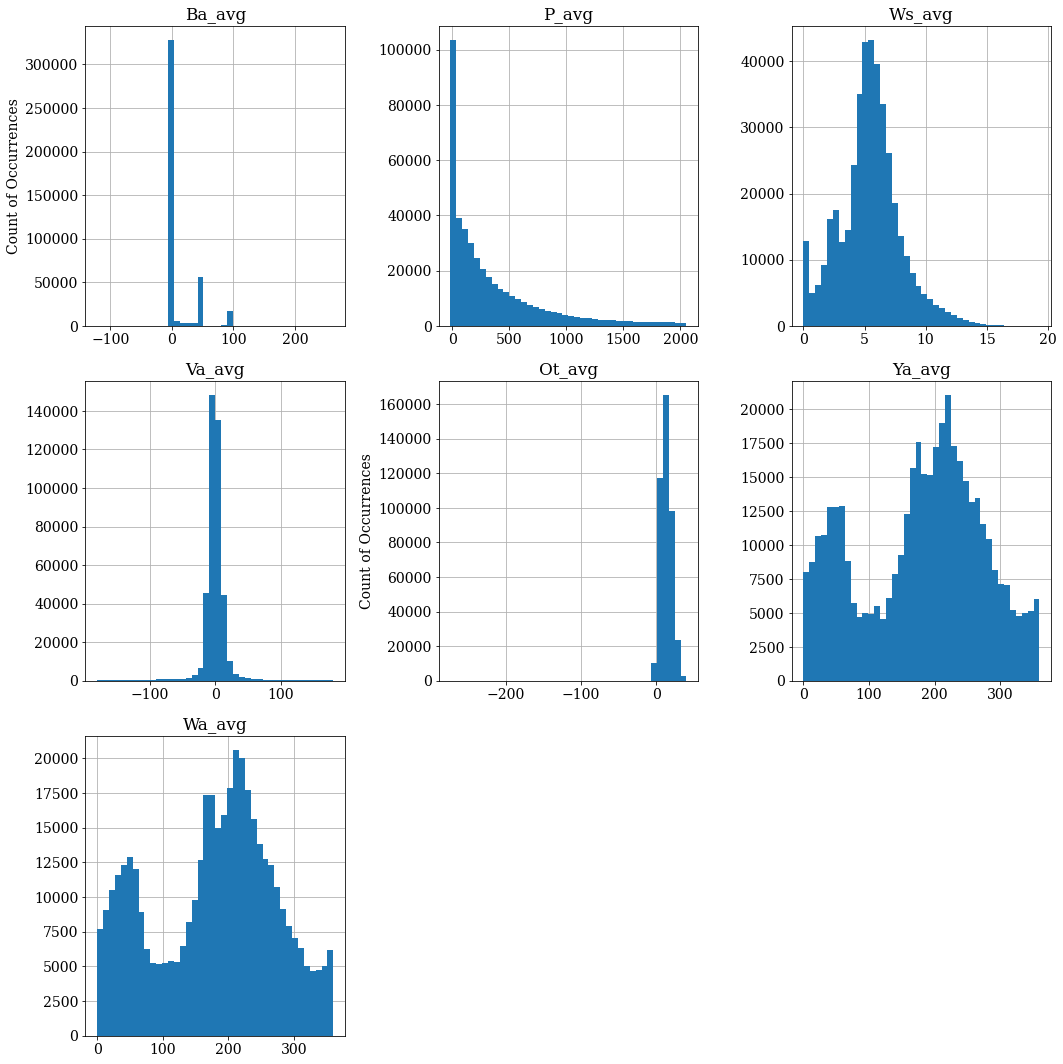

In [13]:
plot.column_histograms(scada_df_tz)

It appears that there are a number of highly frequent values in these distributions, so we can dive into that further to see if we have some unresponsive sensors, in which case the data will need to be invalidated for later analysis. In the below analysis of repeated behaviors in the data, it seems that we should be flagging potentially unresponsive sensors (see Step 5 for more details).

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


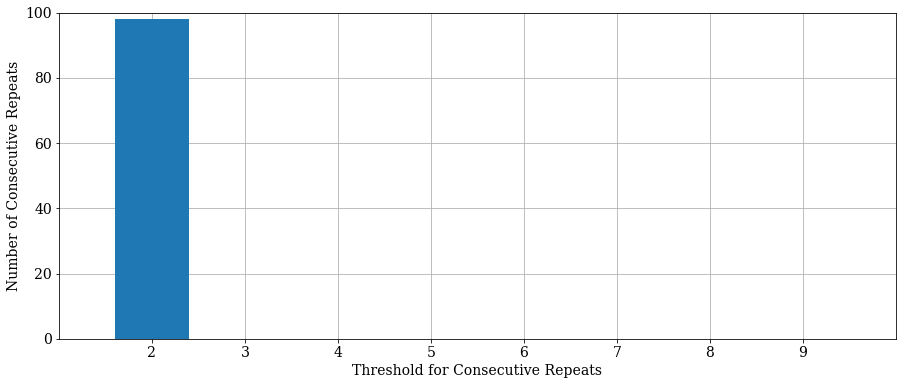

In [14]:
# Only check data for a single turbine to avoid any spurious findings
single_turbine_df = scada_df_tz.loc[scada_df_tz.Wind_turbine_name == "R80736"].copy()

# Identify consecutive data readings
ix_consecutive = single_turbine_df.Va_avg.diff(1) != 0

# Determine how many consecutive occurences are for various thresholds, starting with 2 repeats
consecutive_counts = {i + 1: (ix_consecutive.rolling(i).sum() == 0).sum() for i in range(1, 10)}

# Plot the distribution of  N occurences for each threshold
plt.bar(consecutive_counts.keys(), consecutive_counts.values(), zorder=10)
plt.grid(zorder=0)
plt.xticks(range(2, 10))
plt.xlim((1, 10))
plt.ylim(0, 100)
plt.ylabel("Number of Consecutive Repeats")
plt.xlabel("Threshold for Consecutive Repeats")
plt.show()

It's evident in the above distribution that this sensor appears to be operating adequately and won't need to have any data flagged for unresponsiveness. However, in the below example, we can see that the temperature data are potentially having faulty data and should therefore be flagged.

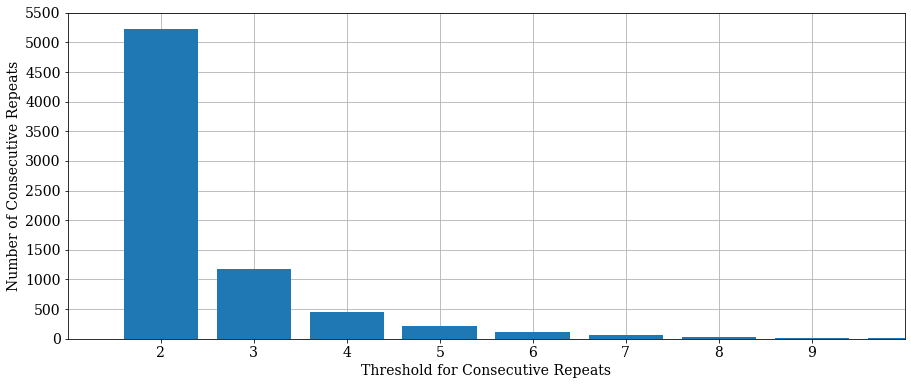

In [15]:
# Identify consecutive data readings
ix_consecutive = single_turbine_df.Ot_avg.diff(1) != 0

# Determine how many consecutive occurences are for various thresholds, starting with 2 repeats
consecutive_counts = {i + 1: (ix_consecutive.rolling(i).sum() == 0).sum() for i in range(1, 10)}

# Plot the distribution of  N occurences for each threshold
plt.bar(consecutive_counts.keys(), consecutive_counts.values(), zorder=10)
plt.grid(zorder=0)
plt.xlim((1, 10))
plt.ylim(0, 5500)
plt.xticks(range(2, 10))
plt.yticks(range(0, 5501, 500))
plt.ylabel("Number of Consecutive Repeats")
plt.xlabel("Threshold for Consecutive Repeats")
plt.show()

#### Checking the power curve distributions

While not contained in the QA module, the `plot_by_id` method is helpful for quickly assessing the quality of our operational power curves.

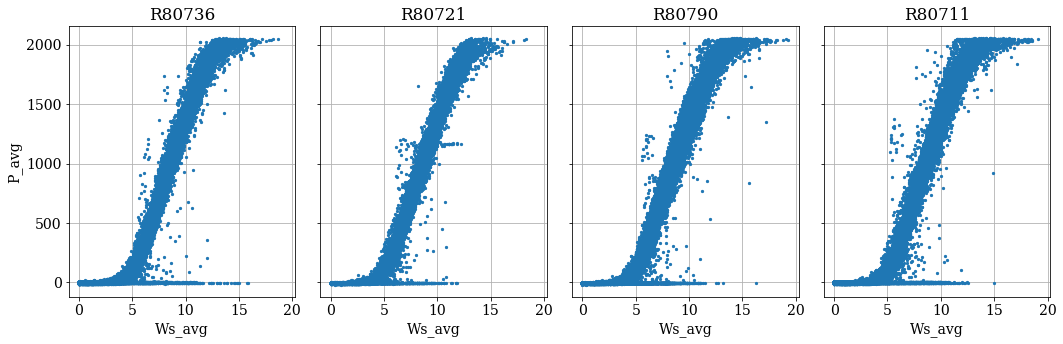

In [16]:
plot.plot_by_id(
    df=scada_df_no_tz,
    id_col="Wind_turbine_name",
    x_axis="Ws_avg",
    y_axis="P_avg",
)

### Step 4: Inspecting the timestamps for DST gaps and duplications

Now, we can get the the duplicate time stamps from each of the data sets, according to each of the original, localized, and UTC time data. This will help us to compare the effects of DST and timezone encoding.

In the below, timezone unaware data, we can see that there is a significant deviation between the local timestamps and the UTC timestamps, especialy around the end of March in both 2018 and 2019, suggesting that there is something missing with the DST data. 

#### Timezone-unaware data

First we'll look only at the data without any timezone encoding, then compare the results to the data where we kept the timezone data encoded to confirm what modifications need to be made to the data. Notice that the UTC converted data are showing duplications at roughly the same time each year when the spring-time European DST shift occurs, and is likely indicating that the original datetime stamps are missing the data to properly shift the duplicates.

In [17]:
dup_orig_no_tz, dup_local_no_tz, dup_utc_no_tz = qa.duplicate_time_identification(
    df=scada_df_no_tz,
    time_col="Date_time",
    id_col="Wind_turbine_name"
)
dup_orig_no_tz.size, dup_local_no_tz.size, dup_utc_no_tz.size

(48, 48, 48)

In [18]:
dup_utc_no_tz

Date_time_utc
2014-03-30 01:00:00+00:00   2014-03-30 01:00:00+00:00
2014-03-30 01:00:00+00:00   2014-03-30 01:00:00+00:00
2014-03-30 01:00:00+00:00   2014-03-30 01:00:00+00:00
2014-03-30 01:00:00+00:00   2014-03-30 01:00:00+00:00
2014-03-30 01:10:00+00:00   2014-03-30 01:10:00+00:00
2014-03-30 01:10:00+00:00   2014-03-30 01:10:00+00:00
2014-03-30 01:10:00+00:00   2014-03-30 01:10:00+00:00
2014-03-30 01:10:00+00:00   2014-03-30 01:10:00+00:00
2014-03-30 01:20:00+00:00   2014-03-30 01:20:00+00:00
2014-03-30 01:20:00+00:00   2014-03-30 01:20:00+00:00
2014-03-30 01:20:00+00:00   2014-03-30 01:20:00+00:00
2014-03-30 01:20:00+00:00   2014-03-30 01:20:00+00:00
2014-03-30 01:30:00+00:00   2014-03-30 01:30:00+00:00
2014-03-30 01:30:00+00:00   2014-03-30 01:30:00+00:00
2014-03-30 01:30:00+00:00   2014-03-30 01:30:00+00:00
2014-03-30 01:30:00+00:00   2014-03-30 01:30:00+00:00
2014-03-30 01:40:00+00:00   2014-03-30 01:40:00+00:00
2014-03-30 01:40:00+00:00   2014-03-30 01:40:00+00:00
2014-03-30 01:

To help confirm there are DST corrections needed in the data, we can also take a lot at the gaps in the timestamps, particularly in October. At a quick glance, the timezone unaware UTC encoding seems to create gaps in the data, likely accounting for the DST shift in the fall.

Based on the duplicated timestamps in the original data, it does seem like there is a DST correction in spring but no duplicate times in the fall. However, even with a UTC conversion, there still appear to be duplications in the data, so there is likely additional analysis needed here. While it appears that there are time gaps in the data for the original inputs, this phenomena switches seasons to the fall for the UTC converted time stamps, likely due to the lack of timezone encoding in the original inputs compared to a corrected timestamp.

In [19]:
gap_orig_no_tz, gap_local_no_tz, gap_utc_no_tz = qa.gap_time_identification(
    df=scada_df_no_tz,
    time_col="Date_time",
    freq="10T"
)
gap_orig_no_tz.size, gap_local_no_tz.size, gap_utc_no_tz.size

(12, 12, 12)

In [20]:
gap_orig_no_tz

0    2015-03-29 02:20:00
1    2015-03-29 02:10:00
2    2014-03-30 02:40:00
3    2014-03-30 02:10:00
4    2015-03-29 02:00:00
5    2015-03-29 02:50:00
6    2014-03-30 02:00:00
7    2015-03-29 02:40:00
8    2015-03-29 02:30:00
9    2014-03-30 02:50:00
10   2014-03-30 02:20:00
11   2014-03-30 02:30:00
Name: Date_time, dtype: datetime64[ns]

In [21]:
gap_utc_no_tz

0    2014-10-26 01:00:00+00:00
1    2015-10-25 01:00:00+00:00
2    2015-10-25 01:50:00+00:00
3    2015-10-25 01:10:00+00:00
4    2014-10-26 01:40:00+00:00
5    2015-10-25 01:30:00+00:00
6    2014-10-26 01:30:00+00:00
7    2015-10-25 01:40:00+00:00
8    2014-10-26 01:50:00+00:00
9    2014-10-26 01:20:00+00:00
10   2015-10-25 01:20:00+00:00
11   2014-10-26 01:10:00+00:00
Name: Date_time_utc, dtype: datetime64[ns, UTC]

Below, we can observe the effects of not having timezones encoded, and what that might mean for potential analyses. In the unaware data, it appears that the original data (blue, solid line, labeled "Original Timestamp") has a time gap in the spring; however, when we compare it to the UTC timestamp (orange, dashed line), it is clear that there is not in fact any gap in the data, and the DST transition has been encoded properly in the data. On the otherhand, it at first appears that there are no gaps in the fall when we make the same comparison, but when looking at the UTC timestamps, we can see that there is a 1 hour gap in the data for both 2014 and 2015. This is in line with our comparison of the original and UTC time gaps above, and further confirms our findings that there are duplicates in the spring and gaps in the fall.

By having the original data and a UTC-converted timestamp it enables us to see any gaps that may appear when there is no timezone data encoded. On the other hand, using the UTC-converted timestamp does not reduce the number of duplications in this dataset that are present in the spring, but helps adjust for seemingly missing or available data. In tandem we can see in the scatter points that there are still duplicates in the spring data just before the DST switch.

In [22]:
# Timezone Unaware
qa.daylight_savings_plot(
    df=scada_df_no_tz,
    local_tz="Europe/Paris",
    id_col="Wind_turbine_name",
    time_col="Date_time",
    power_col="P_avg",
    freq="10T",
    hour_window=3  # default value
)

OverflowError: int too big to convert

<Figure size 1400x2000 with 1 Axes>

IndexError: index 0 is out of bounds for axis 0 with size 0

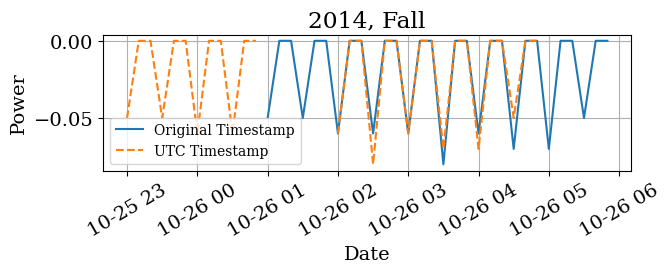

OverflowError: int too big to convert

<Figure size 1400x2000 with 1 Axes>

<ipython-input-33-554aa245c638>:139: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_years, 2, 2 * i + 2)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [33]:
import openoa.utils.timeseries as ts
from openoa.utils import qa

####################################
df=scada_df_no_tz
local_tz="Europe/Paris"
id_col="Wind_turbine_name"
time_col="Date_time"
power_col="P_avg"
freq="10T"
hour_window=3
####################################

_dst = "is_dst"
t_utc = f"{time_col}_utc"
t_local = f"{time_col}_localized"

# Get data for one of the turbines
df_dst = df.loc[df[id_col] == df[id_col].unique()[0]]
df_full = df_dst.copy()

# Locate the missing timestamps, convert to UTC, and recreate DST and UTC-offset columns
missing_original = ts.find_time_gaps(df_dst[time_col], freq)
missing_local = ts.find_time_gaps(df_dst[t_local], freq)
missing_utc = ts.find_time_gaps(df_dst[t_utc], freq)

missing_df = pd.DataFrame([], columns=df.columns)
missing_df.loc[:, t_utc] = missing_utc
missing_df.loc[:, t_local] = missing_local
missing_df.loc[:, time_col] = missing_original
missing_df = missing_df.set_index(t_utc, drop=False)

# Append and resort the missing timestamps, then convert to local time
df_full = df_full.append(missing_df).sort_values(time_col)
try:
    df_full = df_full.tz_convert(local_tz)
except TypeError:
    pass

time_duplications, time_duplications_utc, _ = qa.duplicate_time_identification(
    df, time_col, id_col
)
years = df_full[time_col].dt.year.unique().astype(int)  # Years in data record
num_years = len(years)
hour_window = pd.Timedelta(hours=hour_window)
plt.figure(figsize=(14, 20))

for i, year in enumerate(years):
    year_data = df_full.loc[df_full[time_col].dt.year == year]
    dst_dates = np.where(year_data[_dst].values)[0]

    # Break the plotting loop if there is a partial year without DST in the data
    if dst_dates.size == 0:
        break

    # Get the start and end DatetimeIndex values
    start_ix = year_data.iloc[dst_dates[0]].name
    end_ix = year_data.iloc[dst_dates[-1] + 1].name

    # Create the data subsets for plotting the appropriate window
    data_spring = qa._get_time_window(year_data, start_ix, hour_window, time_col, t_local, t_utc)
    data_fall = qa._get_time_window(year_data, end_ix, hour_window, time_col, t_local, t_utc)

    data_spring = data_spring.sort_values(
        [time_col, power_col], na_position="first"
    ).drop_duplicates(subset=time_col, keep="last")
    data_fall = data_fall.sort_values(
        [time_col, power_col], na_position="first"
    ).drop_duplicates(subset=time_col, keep="last")

    # Plot each as side-by-side subplots
    plt.subplot(num_years, 2, 2 * i + 1)
    if np.sum(~np.isnan(data_spring[power_col])) > 0:
        # For localized time, we want to ensure we're capturing the DST switch as missing data
        ix_filter, time_stamps = qa._remove_tz(data_spring, time_col)
        time_stamps = pd.Series(time_stamps[ix_filter])
        power_data = data_spring.loc[ix_filter, power_col].tolist()

        # Find the missing data points on the timezone stripped data and append
        # it to the time stamps, then identify where to insert NaN in the power data
        missing = ts.find_time_gaps(time_stamps, freq)
        missing = pd.to_datetime(missing.values).to_pydatetime()
        time_stamps = np.append(time_stamps, missing)
        time_stamps.sort()
        nan_ix = sorted([np.where(el == time_stamps)[0][0] for el in missing])
        for ix in nan_ix:
            power_data.insert(ix, float("nan"))

        plt.plot(
            time_stamps,
            power_data,
            label="Original Timestamp",
            c="tab:blue",
            lw=1.5,
        )

        # Plot the duplicated time stamps as scatter points
        duplications = data_spring.loc[data_spring[time_col].isin(time_duplications)]
        if duplications.shape[0] > 0:
            ix_filter, time_stamps = qa._remove_tz(duplications, time_col)
            plt.scatter(
                time_stamps[ix_filter],
                duplications.loc[ix_filter, power_col],
                c="tab:blue",
                label="Original Timestamp Duplicates",
            )

        # Find bad timestamps, then fill in any potential UTC time gaps due the focus on the input time field
        ix_filter, time_stamps = qa._remove_tz(data_spring, t_utc)
        data_spring = ts.gap_fill_data_frame(data_spring[ix_filter], t_utc, freq)
        ix_filter, time_stamps = qa._remove_tz(data_spring, t_utc)
        plt.plot(
            time_stamps[ix_filter],
            data_spring.loc[ix_filter, power_col],
            label="UTC Timestamp",
            c="tab:orange",
            linestyle="--",
        )

        # Plot the duplicated time stamps as scatter points
        duplications = data_spring.loc[data_spring[t_utc].isin(time_duplications_utc)]
        if duplications.shape[0] > 0:
            ix_filter, time_stamps = qa._remove_tz(duplications, t_utc)
            plt.scatter(
                time_stamps[ix_filter],
                duplications.loc[ix_filter, power_col],
                c="tab:orange",
                label="UTC Timestamp Duplicates",
            )
        plt.show()

    plt.title(f"{year}, Spring")
    plt.ylabel("Power")
    plt.xlabel("Date")
    plt.legend(loc="lower left", fontsize=10)
    plt.xticks(rotation=30)
    plt.grid(True)

    plt.subplot(num_years, 2, 2 * i + 2)
    if np.sum(~np.isnan(data_fall[power_col])) > 0:
        ix_filter, time_stamps = qa._remove_tz(data_fall, time_col)
        plt.plot(
            time_stamps[ix_filter],
            data_fall.loc[ix_filter, power_col],
            label="Original Timestamp",
            c="tab:blue",
            lw=1.5,
        )

        # Plot the duplicated time stamps as scatter points
        duplications = data_fall.loc[data_fall[time_col].isin(time_duplications)]
        if duplications.shape[0] > 0:
            ix_filter, time_stamps = qa._remove_tz(duplications, time_col)
            plt.scatter(
                time_stamps[ix_filter],
                duplications.loc[ix_filter, power_col],
                c="tab:blue",
                label="Original Timestamp Duplicates",
            )

        # Find bad timestamps, then fill in any potential UTC time gaps due the focus on the input time field
        ix_filter, time_stamps = qa._remove_tz(data_fall, t_utc)
        data_fall = ts.gap_fill_data_frame(data_fall[ix_filter], t_utc, freq)
        ix_filter, time_stamps = qa._remove_tz(data_fall, t_utc)
        plt.plot(
            time_stamps[ix_filter],
            data_fall.loc[ix_filter, power_col],
            label="UTC Timestamp",
            c="tab:orange",
            linestyle="--",
        )

        # Plot the duplicated time stamps as scatter points
        duplications = data_fall.loc[data_fall[t_utc].isin(time_duplications_utc)]
        if duplications.shape[0] > 0:
            ix_filter, time_stamps = qa._remove_tz(duplications, t_utc)
            plt.scatter(
                time_stamps[ix_filter],
                duplications.loc[ix_filter, power_col],
                c="tab:orange",
                label="UTC Timestamp Duplicates",
            )

    plt.title(f"{year}, Fall")
    plt.ylabel("Power")
    plt.xlabel("Date")
    plt.legend(loc="lower left", fontsize=10)
    plt.xticks(rotation=30)
    plt.grid(True)

plt.tight_layout()
plt.show()


In [34]:
year_data

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg,Date_time_localized,Date_time_utc,utc_offset,is_dst
Date_time_utc,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,R80736,2015-01-01 00:00:00,-0.99,201.570010,5.28,-0.22,0.98,45.25,45.029999,2015-01-01 00:00:00+01:00,2014-12-31 23:00:00+00:00,0 days 01:00:00,False
2015-01-01 00:10:00+01:00,R80736,2015-01-01 00:10:00,-0.99,258.690000,5.71,-7.74,1.10,45.25,37.520000,2015-01-01 00:10:00+01:00,2014-12-31 23:10:00+00:00,0 days 01:00:00,False
2015-01-01 00:20:00+01:00,R80736,2015-01-01 00:20:00,-0.99,247.539990,5.81,-11.98,1.18,45.25,33.279999,2015-01-01 00:20:00+01:00,2014-12-31 23:20:00+00:00,0 days 01:00:00,False
2015-01-01 00:30:00+01:00,R80736,2015-01-01 00:30:00,-0.99,220.690000,5.77,-15.01,1.19,45.25,30.230000,2015-01-01 00:30:00+01:00,2014-12-31 23:30:00+00:00,0 days 01:00:00,False
2015-01-01 00:40:00+01:00,R80736,2015-01-01 00:40:00,-0.99,213.440000,5.90,-17.40,1.10,45.25,27.860001,2015-01-01 00:40:00+01:00,2014-12-31 23:40:00+00:00,0 days 01:00:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 23:10:00+01:00,R80736,2015-12-31 23:10:00,-0.99,87.519997,4.63,-9.03,5.43,185.73,176.710010,2015-12-31 23:10:00+01:00,2015-12-31 22:10:00+00:00,0 days 01:00:00,False
2015-12-31 23:20:00+01:00,R80736,2015-12-31 23:20:00,-0.99,78.050003,4.54,-10.28,5.52,185.73,175.460010,2015-12-31 23:20:00+01:00,2015-12-31 22:20:00+00:00,0 days 01:00:00,False
2015-12-31 23:30:00+01:00,R80736,2015-12-31 23:30:00,-0.99,77.209999,4.50,-8.34,5.64,185.73,177.399990,2015-12-31 23:30:00+01:00,2015-12-31 22:30:00+00:00,0 days 01:00:00,False


In [36]:
start_ix, end_ix

(Timestamp('2014-10-26 02:40:00+0100', tz='Europe/Paris'),
 Timestamp('2015-10-25 03:00:00+0100', tz='Europe/Paris'))

In [42]:
np.where(year_data[_dst].values)[0]

array([12540, 12541, 12542, ..., 42789, 42790, 42791])

In [45]:
year_data = df_full.loc[df_full[time_col].dt.year == year]
dst_dates = np.where(year_data[_dst].values)[0]

# Get the start and end DatetimeIndex values
start_ix = year_data.iloc[dst_dates[0]].name
end_ix = year_data.iloc[dst_dates[-1] + 1].name

# Create the data subsets for plotting the appropriate window
data_spring = qa._get_time_window(year_data, start_ix, hour_window, time_col, t_local, t_utc)
data_fall = qa._get_time_window(year_data, end_ix, hour_window, time_col, t_local, t_utc)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [50]:
year_data = df_full.loc[df_full[time_col].dt.year == year]

In [57]:
dst_dates = np.where(year_data[_dst].values)[0]
dst_dates[0], dst_dates[-1]

(12540, 42791)

In [59]:
year_data.iloc[[dst_dates[0]]]

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg,Date_time_localized,Date_time_utc,utc_offset,is_dst
Date_time_utc,,,,,,,,,,,,,
2014-10-26 02:40:00+01:00,NaN,2015-03-29 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-10-26 02:40:00+01:00,2014-10-26 01:40:00+00:00,NaT,NaN


In [61]:
df_full.iloc[12500:12600]

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg,Date_time_localized,Date_time_utc,utc_offset,is_dst
Date_time_utc,,,,,,,,,,,,,
2014-03-28 20:20:00+01:00,R80736,2014-03-28 20:20:00,44.990002,0.000000,1.47,-30.420000,14.200000,191.220000,160.810000,2014-03-28 20:20:00+01:00,2014-03-28 19:20:00+00:00,0 days 01:00:00,False
2014-03-28 20:30:00+01:00,R80736,2014-03-28 20:30:00,44.990002,0.000000,1.46,-38.189999,14.040000,191.220000,153.039990,2014-03-28 20:30:00+01:00,2014-03-28 19:30:00+00:00,0 days 01:00:00,False
2014-03-28 20:40:00+01:00,R80736,2014-03-28 20:40:00,44.990002,-0.030000,1.00,-42.880001,14.000000,191.220000,148.340000,2014-03-28 20:40:00+01:00,2014-03-28 19:40:00+00:00,0 days 01:00:00,False
2014-03-28 20:50:00+01:00,R80736,2014-03-28 20:50:00,44.990002,0.000000,1.92,-37.380001,13.830000,191.220000,153.840000,2014-03-28 20:50:00+01:00,2014-03-28 19:50:00+00:00,0 days 01:00:00,False
2014-03-28 21:00:00+01:00,R80736,2014-03-28 21:00:00,44.990002,0.000000,1.32,-47.720001,13.890000,191.220000,143.500000,2014-03-28 21:00:00+01:00,2014-03-28 20:00:00+00:00,0 days 01:00:00,False
2014-03-28 21:10:00+01:00,R80736,2014-03-28 21:10:00,44.990002,-0.030000,1.65,-39.389999,13.690000,191.220000,151.820010,2014-03-28 21:10:00+01:00,2014-03-28 20:10:00+00:00,0 days 01:00:00,False
2014-03-28 21:20:00+01:00,R80736,2014-03-28 21:20:00,44.990002,0.000000,1.14,-41.080002,13.830000,191.220000,150.140000,2014-03-28 21:20:00+01:00,2014-03-28 20:20:00+00:00,0 days 01:00:00,False
2014-03-28 21:30:00+01:00,R80736,2014-03-28 21:30:00,44.990002,0.000000,0.32,-34.430000,13.790000,191.220000,156.780000,2014-03-28 21:30:00+01:00,2014-03-28 20:30:00+00:00,0 days 01:00:00,False
2014-03-28 21:40:00+01:00,R80736,2014-03-28 21:40:00,44.990002,-0.030000,0.78,-19.280001,13.880000,191.220000,171.929990,2014-03-28 21:40:00+01:00,2014-03-28 20:40:00+00:00,0 days 01:00:00,False


#### Timezone-aware data

We see a similar finding for timezeone-aware data, below, for the both the number of duplications and gaps, likely confirming our hunches from above.

In [ ]:
dup_orig_tz, dup_local_tz, dup_utc_tz = qa.duplicate_time_identification(
    df=scada_df_tz,
    time_col="Date_time",
    id_col="Wind_turbine_name"
)

In [ ]:
dup_orig_tz.size, dup_local_tz.size, dup_utc_tz.size

In [ ]:
dup_utc_tz

In [ ]:
gap_orig_tz, gap_local_tz, gap_utc_tz = qa.gap_time_identification(
    df=scada_df_tz,
    time_col="Date_time",
    freq="10T"
)
gap_orig_tz.size, gap_local_tz.size, gap_utc_tz.size

In [ ]:
gap_utc_tz

Again, we see a high degree of similarity between the two examples, and so can confirm that we have some duplicated data in the spring unrelated to the DST shift, and some missing data in the fall likely due to the DST shift. Additionally, we can confirm that the Europe/Paris timezone is in fact the encoding of our original data, and should therefore be converted to UTC for later analyses.

In [ ]:
# Timezone Aware
qa.daylight_savings_plot(
    df=scada_df_tz,
    local_tz="Europe/Paris",
    id_col="Wind_turbine_name",
    time_col="Date_time",
    power_col="P_avg",
    freq="10T",
    hour_window=3  # default value
)

### Step 5: Translating this work into a data loading script for `PlantData`

The following description summarizes the steps taken to successfully import the ENGIE SCADA data based on the above analysis, and are implemented in the `project_ENGIE.prepare()` method. It should be noted that this method is cleaned up to provide users with an easy to follow example, it could also be contained in an analysis notebook, stand-alone script, etc., as long as it is able to feed into `PlantData` at the end of it.

1. From [Step 2](#Step-2:-Convert-the-timestamps-to-proper-timestamp-data-objects) and [Step 4](#Step-4:-Inspecting-the-timestamps-for-DST-gaps-and-duplications) we found that the data is in local time and should be converted to UTC for clarity in the timestamps. THis corresponds with line `project_ENGIE.py:79`.
2. Additionally from [Step 4](#Step-4:-Inspecting-the-timestamps-for-DST-gaps-and-duplications), it was clear that duplicated timestamp data will need to be removed, corresponding to line `project_ENGIE.py:82`
3. In [Step 3](#Step-3:-Dive-into-the-data), there is an oversized range for the temperature data, so this data will be invalidated, corresponding to line `project_ENGIE.py:86`
4. In [Step 3](#Step-3:-Dive-into-the-data), the wind vane direction ("Va_avg") and temperature ("Ot_avg") fields seemed to have a large number duplicated data that were identified, so these data are flagged and invalidated, which corresponds to lines `project_ENGIE.py:88-102`
5. Finally, in [Step 3](#Step-3:-Dive-into-the-data), it also should be noted that the pitch direction ranges from 0 to 360 degrees, and this will be corrected to the range of [-180, 180], which corresponds to lines: `project_ENGIE.py:105-107`

The remainder of the data do not need modification aside from additional variable calculations (see `project_ENGIE.py` for more details) and the aforementioned timestamp conversions.

### Step 6: `PlantData` in action

In `project_ENGIE.prepare()` there are two methods to return the data: by dataframe (`return_value="dataframes"`) and by `PlantData` (`return_value="plantdata"`), which are both demonstrated below.

For the dataframe return selection, below it is also demonstrated how to load the dataframes into a `PlantData` object. A couple of things to notice about the creation of the the v3 `PlantData` object: 
- `metadata`: This field is what maps the OpenOA column convention to the user's column naming convention (`PlantData.update_column_names(to_original=True)` enables users to remap the data back to their original naming convention), in addition to a few other plant metadata objects.
- `analysis_type`: This field controls how the data will be validated, if at all, based on the analysis requirements defined in `openoa.plant.ANALYSIS_REQUIREMENTS`.


In [ ]:
scada_df, meter_df, curtail_df, asset_df, reanalysis_dict = project_ENGIE.prepare(
    path="data/la_haute_borne",
    return_value="dataframes"
)

engie = PlantData(
    analysis_type=None,  # No validation desired at this point in time
    metadata="data/plant_meta.yml",
    scada=scada_df,
    meter=meter_df,
    curtail=curtail_df,
    asset=asset_df,
    reanalysis=reanalysis_dict,
)

Below is a summary of what the `PlantData` and `PlantMetaData` object specifications are, which are both new or effectively new as of version 3.0

#### `PlantData` documentation

In [ ]:
print(PlantData.__doc__)

#### `PlantMetaData` Documentation

In [ ]:
from openoa.plant import PlantMetaData
print(PlantMetaData.__doc__)

#### `PlantData` validation

Because `PlantData` is an attrs dataclass, it enables to support automatic conversion and validation of variables, which enables users to change analysis types as they work through their data. Below is a demonstration of what happens when we add an invalid analysis type (which fails to enable it), add the "MonteCarloAEP" analysis type (which passes the validation), and then further add in the "all" analysis type (which fails).

In [ ]:
try:
    engie.analysis_type = "MonteCarlo"
except ValueError as e:
    print(e)

In [ ]:
engie.analysis_type = "MonteCarloAEP"
engie.validate()

Notice that in the above cell, the data validates successfully for the MonteCarloAEP analysis, but below, when we append the `"all"` type, the validation fails. The below failure is because when `"all"` is input to `analysis_type`, it checks all of the data, and not just the analysis categories. In this case, there are no inputs to `tower` and `status`, so each of the checks will fail for all of the required columns by the metadata classifications.

In [ ]:
engie.analysis_type.append("all")
print(f"The new analysis types now has all and MonteCarloAEP: {engie.analysis_type}")
try:
    engie.validate()
except ValueError as e: # Catch the error message so that the whole notebook can run
    print(e)

Below, the ENGIE data has been re-validated for a "MonteCarloAEP" analysis, so that it can be saved for later, and reloaded as the cleaned up version for easier importing.

In [ ]:
engie.analysis_type = "MonteCarloAEP"
engie.validate()

In [ ]:
data_path = "data/cleansed"
engie.to_csv(save_path=data_path, with_openoa_col_names=True)

In [ ]:
engie_clean = PlantData(
    metadata=f"{data_path}/metadata.yml",
    scada=f"{data_path}/scada.csv",
    meter=f"{data_path}/meter.csv",
    curtail=f"{data_path}/curtail.csv",
    status=f"{data_path}/scada.csv",
    asset=f"{data_path}/asset.csv",
    reanalysis={
        "era5": f"{data_path}/reanalysis_era5.csv",
        "merra2": f"{data_path}/reanalysis_merra2.csv"
    },
)